In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
from sklearn.metrics import accuracy_score
import itertools


In [2]:
df= pd.read_csv("../../data/perfectly_DigitalMusic.csv",sep="\t")

In [3]:
df.head(2)

,Unnamed: 0,asin,overall,summary,reviewText,reviewText_new
0,0,5555991584,5.0,Enya's last great album,"It's hard to believe ""Memory of Trees"" came ou...","hard believe ""memory trees"" came 11 years ago;..."
1,1,5555991584,5.0,Enya at her most elegant,"A clasically-styled and introverted album, Mem...","clasically-styled introverted album, memory tr..."


# Data Cleaning

In [4]:
df.isnull().sum()

Unnamed: 0        0
asin              0
overall           0
summary           0
reviewText        1
reviewText_new    1
dtype: int64

In [5]:
df=df.drop(df.columns[df.columns.str.contains('unnamed',case=False)],axis=1)

In [6]:
df.drop(df[df.reviewText.isnull()].index,inplace=True)
df.drop(df[df.reviewText_new.isnull()].index,inplace=True)

In [7]:
df.isnull().sum()

asin              0
overall           0
summary           0
reviewText        0
reviewText_new    0
dtype: int64

In [8]:
df.tail(3)

,asin,overall,summary,reviewText,reviewText_new
64703,B00KILDVEI,5.0,Five Stars,"I absolutely love this song, it downloaded fin...","absolutely love song, downloaded fine, would r..."
64704,B00KILDVEI,3.0,Well-crafted song,"Reggae, island beats aren't really my cup of t...","reggae, island beats really cup team. so, part..."
64705,B00KILDVEI,1.0,Souless Reggae,Magic! is a Canadian band that incorporates re...,magic! canadian band incorporates reggae pop s...


---------------------------------

# Classify overall feature into 3 types of sentiment: negative,neutral,positive 

df.overall.replace('postive','positive')

df.overall.replace('[4,5]','1')

df.overall.replace('[3]','1')

df.overall.replace('[1,2]','-1')

In [9]:
df.loc[df.overall==3,'overall']='neutral'
df.loc[df.overall==1,'overall']='negative'
df.loc[df.overall==2,'overall']='negative'
df.loc[df.overall==4,'overall']='postive'
df.loc[df.overall==5,'overall']='postive'

In [10]:
df.head(3)

,asin,overall,summary,reviewText,reviewText_new
0,5555991584,postive,Enya's last great album,"It's hard to believe ""Memory of Trees"" came ou...","hard believe ""memory trees"" came 11 years ago;..."
1,5555991584,postive,Enya at her most elegant,"A clasically-styled and introverted album, Mem...","clasically-styled introverted album, memory tr..."
2,5555991584,postive,The best so far,I never thought Enya would reach the sublime h...,never thought enya would reach sublime heights...


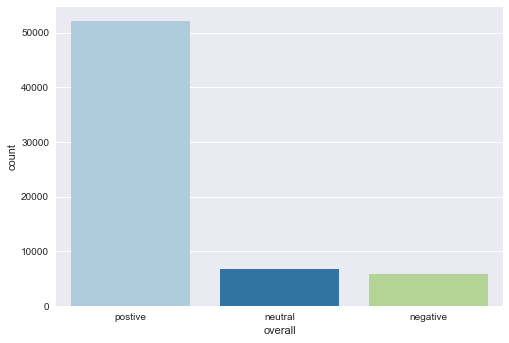

In [11]:
sns.countplot(x="overall", data=df, palette="Paired");

In [12]:
df.groupby('overall').size()

overall
negative     5801
neutral      6788
postive     52116
dtype: int64

### => Class Imbalance in severe. Positive/Negative = 52116/5801 = 8.9 times

-------------------------------

# Class Imbalance

### Feature selection

In [13]:
feature_columns = ['reviewText_new','summary']
X = df[feature_columns]
Y = df.overall

### Vectorizer with Tf-Idf

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df = 0.3,#max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words". For example:
                                          #max_df = 0.50 means "ignore terms that appear in more than 50% of the documents".
                                          #max_df = 25 means "ignore terms that appear in more than 25 documents".
                             stop_words='english',
                             sublinear_tf=True, 
                             use_idf=True,
                             lowercase=True)

### Transform

In [15]:
from scipy.sparse import hstack
xreview_tfidf = vectorizer.fit_transform(X['reviewText_new'])
xsummary_tfidf = vectorizer.fit_transform(X['summary'])
x_review_summary_tfidf = hstack([xsummary_tfidf,xreview_tfidf])

In [16]:
print("\n",xreview_tfidf.ceil,"\n",xsummary_tfidf.ceil)


 <bound method _create_method.<locals>.method of <64705x116089 sparse matrix of type '<class 'numpy.float64'>'
	with 4506826 stored elements in Compressed Sparse Row format>> 
 <bound method _create_method.<locals>.method of <64705x17574 sparse matrix of type '<class 'numpy.float64'>'
	with 189312 stored elements in Compressed Sparse Row format>>


In [17]:
print("xreview_tfidf's shape =            {}\nxsummary_tfidf's shape =           {}\nx_review_summary_tfidf's shape =   {}"
      .format(xreview_tfidf.shape,xsummary_tfidf.shape,x_review_summary_tfidf.shape))

xreview_tfidf's shape =            (64705, 116089)
xsummary_tfidf's shape =           (64705, 17574)
x_review_summary_tfidf's shape =   (64705, 133663)


### Train test split

In [18]:
from sklearn.model_selection import train_test_split
x_review_train, x_review_test, y_review_train, y_review_test = train_test_split(
    xreview_tfidf, df.overall, test_size=0.2, random_state=42)
x_summary_train, x_summary_test, y_summary_train, y_summary_test = train_test_split(
    xsummary_tfidf, df.overall, test_size=0.2, random_state=42)
x_review_summary_train, x_review_summary_test, y_review_summary_train, y_review_summary_test = train_test_split(
    x_review_summary_tfidf, df.overall, test_size=0.2, random_state=42)

# Time to classify using Review feature

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from operator import itemgetter

names = ["MultinomialNB" ] #"Linear SVM"
classifiers = [
    MultinomialNB()
    #SVC(kernel="linear", C=0.025)
    ]

# iterate over classifiers
results = {}
k_fold_results = {}

for name, clf in zip(names, classifiers):
    print ("Training " + name + " classifier...")
    print("Doing Houd-out...")
    clf.fit(x_review_train, y_review_train)
    score = clf.score(x_review_test,y_review_test)
    results[name] = score
    print("Doing K-fold cross validation...")
    value_cross_val_score = cross_val_score(clf, xreview_tfidf, df.overall, cv=5).mean()
    k_fold_results[name]= value_cross_val_score
    predicts = clf.predict(x_review_test)
    print ("Accuracy Rate, which is calculated by accuracy_score() is: %f" % accuracy_score(y_review_test, predicts))
print ("---------------------------")
print ("Evaluation results")
print ("---------------------------")

# sorting results and print out
sorted(results.items(), key=itemgetter(1)) #The key= parameter of sort requires a key function (to be applied to be objects to be sorted) rather than a single key value and
#that is just what operator.itemgetter(1) will give you: A function that grabs the first item from a list-like object.
for name in results:
    print ("Hold-out: ",name + " accuracy: %0.3f" % results[name])
    print ("Cross validation 5-fold: ",name + " accuracy: %0.3f" % k_fold_results[name])
feature= []
performance = []
feature.append("review")
performance.append(list(results.values())[0])

Training MultinomialNB classifier...
Doing Houd-out...
Doing K-fold cross validation...
Accuracy Rate, which is calculated by accuracy_score() is: 0.804343
---------------------------
Evaluation results
---------------------------
Hold-out:  MultinomialNB accuracy: 0.804
Cross validation 5-fold:  MultinomialNB accuracy: 0.805


# Time to classify using Summary feature

In [20]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from operator import itemgetter

names = ["MultinomialNB" ] #"Linear SVM"
classifiers = [
    MultinomialNB()
    #SVC(kernel="linear", C=0.025)
    ]

# iterate over classifiers
results = {}
k_fold_results = {}

for name, clf in zip(names, classifiers):
    print ("Training " + name + " classifier...")
    print("Doing Houd-out...")
    clf.fit(x_summary_train,y_summary_train)
    score = clf.score(x_summary_test,y_summary_test)
    results[name] = score
    print("Doing K-fold cross validation...")
    value_cross_val_score = cross_val_score(clf, xsummary_tfidf, df.overall, cv=5).mean()
    k_fold_results[name]= value_cross_val_score
    predicts = clf.predict(x_summary_test)
    print ("Accuracy Rate, which is calculated by accuracy_score() is: %f" % accuracy_score(y_summary_test, predicts))
print ("---------------------------")
print ("Evaluation results")
print ("---------------------------")

# sorting results and print out
sorted(results.items(), key=itemgetter(1)) #The key= parameter of sort requires a key function (to be applied to be objects to be sorted) rather than a single key value and
#that is just what operator.itemgetter(1) will give you: A function that grabs the first item from a list-like object.
for name in results:
    print ("Hold-out: ",name + " accuracy: %0.3f" % results[name])
    print ("Cross validation 5-fold: ",name + " accuracy: %0.3f" % k_fold_results[name])
feature.append("summary")
performance.append(list(results.values())[0])

Training MultinomialNB classifier...
Doing Houd-out...
Doing K-fold cross validation...
Accuracy Rate, which is calculated by accuracy_score() is: 0.813307
---------------------------
Evaluation results
---------------------------
Hold-out:  MultinomialNB accuracy: 0.813
Cross validation 5-fold:  MultinomialNB accuracy: 0.811


# Time to classify using Summary and Review features

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from operator import itemgetter

names = ["MultinomialNB" ] #"Linear SVM"
classifiers = [
    MultinomialNB()
    #SVC(kernel="linear", C=0.025)
    ]

# iterate over classifiers
results = {}
k_fold_results = {}

for name, clf in zip(names, classifiers):
    print ("Training " + name + " classifier...")
    print("Doing Houd-out...")
    clf.fit(x_review_summary_train,  y_review_summary_train)
    score = clf.score(x_review_summary_test,y_review_summary_test)
    results[name] = score
    print("Doing K-fold cross validation...")
    value_cross_val_score = cross_val_score(clf, x_review_summary_tfidf, df.overall, cv=5).mean()
    k_fold_results[name]= value_cross_val_score
    predicts = clf.predict(x_review_summary_test)
    print ("Accuracy Rate, which is calculated by accuracy_score() is: %f" % accuracy_score(y_review_summary_test, predicts))
print ("---------------------------")
print ("Evaluation results")
print ("---------------------------")

# sorting results and print out
sorted(results.items(), key=itemgetter(1)) #The key= parameter of sort requires a key function (to be applied to be objects to be sorted) rather than a single key value and
#that is just what operator.itemgetter(1) will give you: A function that grabs the first item from a list-like object.
for name in results:
    print ("Hold-out: ",name + " accuracy: %0.3f" % results[name])
    print ("Cross validation 5-fold: ",name + " accuracy: %0.3f" % k_fold_results[name])
feature.append("review + summary")
performance.append(list(results.values())[0])

Training MultinomialNB classifier...
Doing Houd-out...
Doing K-fold cross validation...
Accuracy Rate, which is calculated by accuracy_score() is: 0.805347
---------------------------
Evaluation results
---------------------------
Hold-out:  MultinomialNB accuracy: 0.805
Cross validation 5-fold:  MultinomialNB accuracy: 0.806


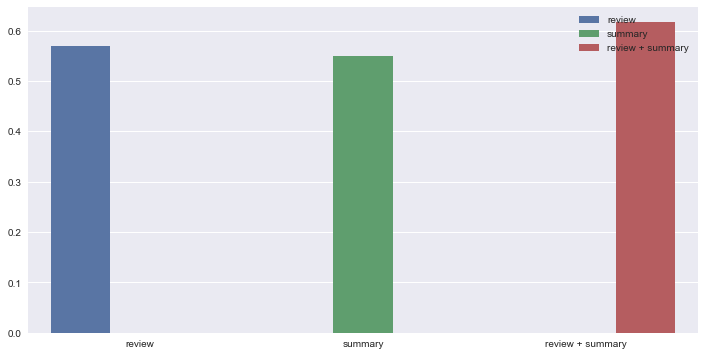

In [44]:
f,ax = plt.subplots(figsize=(12,6))
sns.barplot(x=feature, y=performance, hue=feature)

------------------------------

# Class Balance

In [23]:
df.overall.value_counts()

postive     52116
neutral      6788
negative     5801
Name: overall, dtype: int64

In [24]:
df.overall.unique()

array(['postive', 'neutral', 'negative'], dtype=object)

In [25]:
overall_pos = df[df['overall']=='postive'].sample(n=6000,random_state=100)
overall_nev = df[df['overall']=='negative']
overall_neu = df[df['overall']=='neutral']
new_overall = overall_pos.append(overall_nev).append(overall_neu)

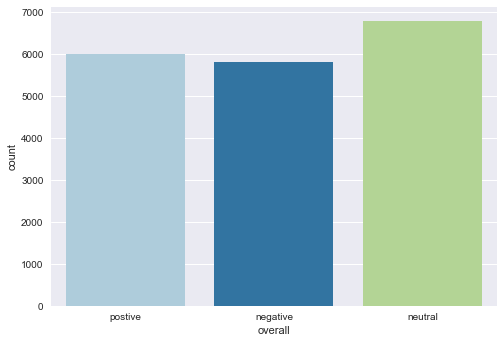

In [26]:
sns.countplot(x="overall", data=new_overall, palette="Paired");

In [27]:
new_overall.head(3)

,asin,overall,summary,reviewText,reviewText_new
26199,B000009S3Z,postive,Amazing Voice,Deborah Cox is one of Canada's best talents ou...,deborah cox one canada's best talents there. c...
45075,B00018D44U,postive,Love it!,"It's different from Come Away with Me, but it ...","different come away me, grew me. definitely di..."
6895,B0000024WG,postive,"Laura Nyro, a truly under-appreciated genius",I hesitate to introduce Nyro to my musical fri...,hesitate introduce nyro musical friends. genya...


## Feature Selection

In [28]:
feature_columns = ['reviewText_new','summary']
X = new_overall[feature_columns]
Y = new_overall.overall

## Vectorizer with Tf-Idf

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df = 0.3,#max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words". For example:
                                          #max_df = 0.50 means "ignore terms that appear in more than 50% of the documents".
                                          #max_df = 25 means "ignore terms that appear in more than 25 documents".
                             stop_words='english',
                             sublinear_tf=True, 
                             use_idf=True,
                             lowercase=True)

## Transform

In [30]:
from scipy.sparse import hstack
xreview_tfidf = vectorizer.fit_transform(X['reviewText_new'])
xsummary_tfidf = vectorizer.fit_transform(X['summary'])
x_review_summary_tfidf = hstack([xsummary_tfidf,xreview_tfidf])

In [31]:
print("xreview_tfidf's shape =            {}\nxsummary_tfidf's shape =           {}\nx_review_summary_tfidf's shape =   {}"
      .format(xreview_tfidf.shape,xsummary_tfidf.shape,x_review_summary_tfidf.shape))

xreview_tfidf's shape =            (18589, 59595)
xsummary_tfidf's shape =           (18589, 9524)
x_review_summary_tfidf's shape =   (18589, 69119)


## Train Test Split

In [32]:
from sklearn.model_selection import train_test_split
x_review_train, x_review_test, y_review_train, y_review_test = train_test_split(
    xreview_tfidf, new_overall.overall, test_size=0.2, random_state=42)
x_summary_train, x_summary_test, y_summary_train, y_summary_test = train_test_split(
    xsummary_tfidf, new_overall.overall, test_size=0.2, random_state=42)
x_review_summary_train, x_review_summary_test, y_review_summary_train, y_review_summary_test = train_test_split(
    x_review_summary_tfidf, new_overall.overall, test_size=0.2, random_state=42)

# Time to classify using Review feature

In [33]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from operator import itemgetter

names = ["MultinomialNB" ] #"Linear SVM"
classifiers = [
    MultinomialNB()
    #SVC(kernel="linear", C=0.025)
    ]

# iterate over classifiers
results = {}
k_fold_results = {}

for name, clf in zip(names, classifiers):
    print ("Training " + name + " classifier...")
    print("Doing Houd-out...")
    clf.fit(x_review_train, y_review_train)
    score = clf.score(x_review_test,y_review_test)
    results[name] = score
    print("Doing K-fold cross validation...")
    value_cross_val_score = cross_val_score(clf, xreview_tfidf, new_overall.overall, cv=5).mean()
    k_fold_results[name]= value_cross_val_score
    predicts = clf.predict(x_review_test)
    print ("Accuracy Rate, which is calculated by accuracy_score() is: %f" % accuracy_score(y_review_test, predicts))

print ("---------------------------")
print ("Evaluation results")
print ("---------------------------")

# sorting results and print out
sorted(results.items(), key=itemgetter(1)) #The key= parameter of sort requires a key function (to be applied to be objects to be sorted) rather than a single key value and
#that is just what operator.itemgetter(1) will give you: A function that grabs the first item from a list-like object.
for name in results:
    print ("Hold-out: ",name + " accuracy: %0.3f" % results[name])
    print ("Cross validation 5-fold: ",name + " accuracy: %0.3f" % k_fold_results[name])
feature= []
performance = []
feature.append("review")
performance.append(list(results.values())[0])

Training MultinomialNB classifier...
Doing Houd-out...
Doing K-fold cross validation...
Accuracy Rate, which is calculated by accuracy_score() is: 0.569123
---------------------------
Evaluation results
---------------------------
Hold-out:  MultinomialNB accuracy: 0.569
Cross validation 5-fold:  MultinomialNB accuracy: 0.522


# Time to classify using Summary feature

In [34]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from operator import itemgetter

names = ["MultinomialNB" ] #"Linear SVM"
classifiers = [
    MultinomialNB()
    #SVC(kernel="linear", C=0.025)
    ]

# iterate over classifiers
results = {}
k_fold_results = {}

for name, clf in zip(names, classifiers):
    print ("Training " + name + " classifier...")
    print("Doing Houd-out...")
    clf.fit(x_summary_train,y_summary_train)
    score = clf.score(x_summary_test,y_summary_test)
    results[name] = score
    print("Doing K-fold cross validation...")
    value_cross_val_score = cross_val_score(clf, xsummary_tfidf, new_overall.overall, cv=5).mean()
    k_fold_results[name]= value_cross_val_score
    predicts = clf.predict(x_summary_test)
    print ("Accuracy Rate, which is calculated by accuracy_score() is: %f" % accuracy_score(y_summary_test, predicts))
print ("---------------------------")
print ("Evaluation results")
print ("---------------------------")

# sorting results and print out
sorted(results.items(), key=itemgetter(1)) #The key= parameter of sort requires a key function (to be applied to be objects to be sorted) rather than a single key value and
#that is just what operator.itemgetter(1) will give you: A function that grabs the first item from a list-like object.
for name in results:
    print ("Hold-out: ",name + " accuracy: %0.3f" % results[name])
    print ("Cross validation 5-fold: ",name + " accuracy: %0.3f" % k_fold_results[name])
feature.append("summary")
performance.append(list(results.values())[0])

Training MultinomialNB classifier...
Doing Houd-out...
Doing K-fold cross validation...
Accuracy Rate, which is calculated by accuracy_score() is: 0.550027
---------------------------
Evaluation results
---------------------------
Hold-out:  MultinomialNB accuracy: 0.550
Cross validation 5-fold:  MultinomialNB accuracy: 0.531


# Time to classify using Review and Summary features

In [35]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from operator import itemgetter
from sklearn.metrics import accuracy_score

names = ["MultinomialNB" ] #"Linear SVM"
classifiers = [
    MultinomialNB()
    #SVC(kernel="linear", C=0.025)
    ]

# iterate over classifiers
results = {}
k_fold_results = {}
y_pred=0
for name, clf in zip(names, classifiers):
    print ("Training " + name + " classifier...")
    print("Doing Houd-out...")
    clf.fit(x_review_summary_train,  y_review_summary_train)
    score = clf.score(x_review_summary_test,y_review_summary_test)
    results[name] = score
    print("Doing K-fold cross validation...")
    value_cross_val_score = cross_val_score(clf, x_review_summary_tfidf, new_overall.overall, cv=5).mean()
    k_fold_results[name]= value_cross_val_score
    predicts = clf.predict(x_review_summary_test)
    print ("Accuracy Rate, which is calculated by accuracy_score() is: %f" % accuracy_score(y_review_summary_test, predicts))
    y_pred =(predicts)
print ("---------------------------")
print ("Evaluation results")
print ("---------------------------")

# sorting results and print out
sorted(results.items(), key=itemgetter(1)) #The key= parameter of sort requires a key function (to be applied to be objects to be sorted) rather than a single key value and
#that is just what operator.itemgetter(1) will give you: A function that grabs the first item from a list-like object.
for name in results:
    print ("Hold-out: ",name + " accuracy: %0.3f" % results[name])
    print ("Cross validation 5-fold: ",name + " accuracy: %0.3f" % k_fold_results[name])
feature.append("review + summary")
performance.append(list(results.values())[0])

Training MultinomialNB classifier...
Doing Houd-out...
Doing K-fold cross validation...
Accuracy Rate, which is calculated by accuracy_score() is: 0.616998
---------------------------
Evaluation results
---------------------------
Hold-out:  MultinomialNB accuracy: 0.617
Cross validation 5-fold:  MultinomialNB accuracy: 0.580


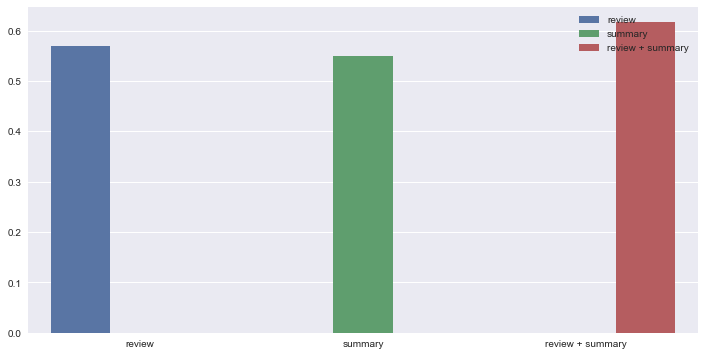

In [43]:
f,ax = plt.subplots(figsize=(12,6))
sns.barplot(x=feature, y=performance, hue=feature)

# Measure the performance after modeling

### Using Accuracy

### Using confusion matrix

In [37]:
y_pred.shape

(3718,)

In [38]:
y_review_summary_test.shape

(3718,)

In [39]:
new_overall.overall.unique()

array(['postive', 'negative', 'neutral'], dtype=object)

Confusion matrix, without normalization
[[ 570  582   40]
 [ 104 1055  168]
 [  35  495  669]]
Normalized confusion matrix
[[ 0.48  0.49  0.03]
 [ 0.08  0.8   0.13]
 [ 0.03  0.41  0.56]]


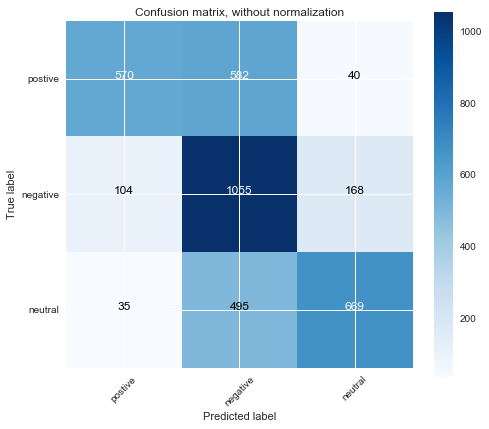

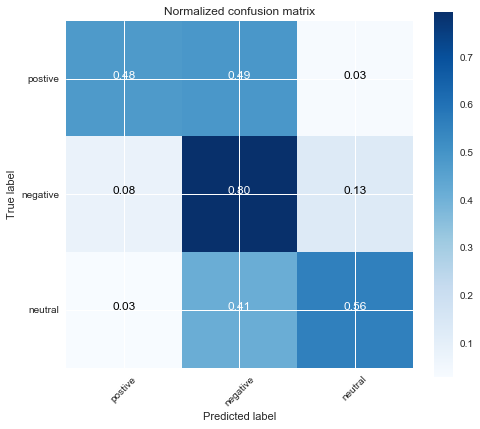

Độ chính xác Accuracy: 61%



In [40]:
from sklearn.metrics import confusion_matrix
import itertools

class_names = new_overall.overall.unique()
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_review_summary_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(7,6))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(7,6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
print('Độ chính xác Accuracy: {}%\n'.format(int(np.diagonal(cnf_matrix).sum()/cnf_matrix.sum()*100)))

Với các bài toán với nhiều lớp dữ liệu, cách biểu diễn bằng màu này rất hữu ích. Các ô màu đậm thể hiện các giá trị cao. Một mô hình tốt sẽ cho một confusion matrix có các phần tử trên đường chéo chính có giá trị lớn, các phần tử còn lại có giá trị nhỏ. Nói cách khác, khi biểu diễn bằng màu sắc, đường chéo có màu càng đậm so với phần còn lại sẽ càng tốt. Từ hai hình trên ta thấy rằng confusion matrix đã chuẩn hoá mang nhiều thông tin hơn. Sự khác nhau được thấy ở ô trên cùng bên trái. Lớp dữ liệu 0 được phân loại không thực sự tốt nhưng trong unnormalized confusion matrix, nó vẫn có màu đậm như hai ô còn lại trên đường chéo chính.




### True/False/ Positive/Negative

In [41]:
performance

[0.56912318450779986, 0.5500268961807423, 0.61699838622915548]

In [42]:
feature

['review', 'summary', 'review + summary']